In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as tr
import skimage.color
from glob import glob

## Own Scripts
from helper import * 
from loss_metrics import *
from unet import *


Using TensorFlow backend.


In [2]:
# initialise variables
train_size = 18300
val_size = 3922
batch_size = 32
resultPath = '/home/dan/Desktop/Datenset_Tower/results/'
epochs = 40

In [3]:
# create generators for training 

trainInputPath = '/home/dan/Desktop/Datenset_Tower/train/images'
trainOutputPath = '/home/dan/Desktop/Datenset_Tower/train/masks'

valInputPath = '/home/dan/Desktop/Datenset_Tower/validate/images'
valOutputPath = '/home/dan/Desktop/Datenset_Tower/validate/masks'

trainGen = loadData(trainInputPath, trainOutputPath, batch_size)
valGen   = loadData(valInputPath, valOutputPath, batch_size)

In [8]:
# initialise new model
model = None
model = UNet((224,224,1), 1, 16, 5, 2.0, batchnorm=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 224, 224, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 224, 224, 16) 64          conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 224, 224, 16) 2320        batch_normalization_23[0][0]     
__________________________________________________________________________________________________
batch_norm

In [ ]:
# load trained Model  
from keras.models import load_model 
model = load_model('ds_step08.h5', custom_objects={'iou_loss': iou_loss})
model.summary()

In [9]:
# Create Callbacks
earlyStop = EarlyStopping(monitor='val_loss', patience = 3)
checkpoint = ModelCheckpoint(resultPath + 'training.h5', save_best_only=True)

In [10]:
model.compile(optimizer=Adam(lr=0.0001), loss=iou_loss, metrics=['accuracy'])

In [11]:
# Train and validate the model 
result = model.fit_generator(trainGen, steps_per_epoch= train_size/batch_size, epochs=epochs, validation_data=valGen, validation_steps=val_size/batch_size, verbose=1, shuffle=True, callbacks=[earlyStop, checkpoint])

Epoch 1/40
572/571 [==============================] - 210s 367ms/step - loss: -0.0476 - acc: 0.8715 - val_loss: -0.0838 - val_acc: 0.9399
Epoch 2/40
572/571 [==============================] - 206s 360ms/step - loss: -0.0816 - acc: 0.9365 - val_loss: -0.1280 - val_acc: 0.9607
Epoch 3/40
572/571 [==============================] - 206s 361ms/step - loss: -0.1373 - acc: 0.9656 - val_loss: -0.2127 - val_acc: 0.9770
Epoch 4/40
572/571 [==============================] - 206s 361ms/step - loss: -0.2367 - acc: 0.9822 - val_loss: -0.3523 - val_acc: 0.9862
Epoch 5/40
572/571 [==============================] - 207s 362ms/step - loss: -0.3677 - acc: 0.9894 - val_loss: -0.4632 - val_acc: 0.9911
Epoch 6/40
572/571 [==============================] - 207s 362ms/step - loss: -0.4795 - acc: 0.9921 - val_loss: -0.4814 - val_acc: 0.9939
Epoch 7/40
572/571 [==============================] - 207s 362ms/step - loss: -0.5466 - acc: 0.9931 - val_loss: -0.5355 - val_acc: 0.9936
Epoch 8/40
572/571 [==============

In [12]:
print(result.history)

{'val_loss': [-0.08380592374671544, -0.128029156428767, -0.21269206356965784, -0.3522671714295908, -0.4631662481539958, -0.4814437067915991, -0.5355393824712286, -0.5629107954549522, -0.5710079935604915, -0.5972446349127933, -0.614815120822249, -0.6190072947287669, -0.6315578032913772, -0.6552784852322603, -0.6561227361199079, -0.6630782764034573, -0.6396838432972921, -0.6525592724624062, -0.6619389760804262], 'val_acc': [0.9399361717403087, 0.960659537948801, 0.9769765422515636, 0.986187540591219, 0.9910567723811129, 0.9938823700194332, 0.9935699387632542, 0.9937828815998562, 0.9946020502086077, 0.9944895311073039, 0.9949065548069073, 0.9951636468130128, 0.9952141372662671, 0.9952826845530404, 0.9953892692687984, 0.9955379040736072, 0.9947308549037216, 0.9956988734836666, 0.9957576562165606], 'loss': [-0.04763744401638625, -0.08161197063049984, -0.13727005777788945, -0.236670839187226, -0.36767092145857266, -0.47951578257513827, -0.5465683898118024, -0.5894053121994102, -0.61968154073

In [13]:
model.save('/home/dan/Desktop/Datenset_Tower/results/training_04.h5')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


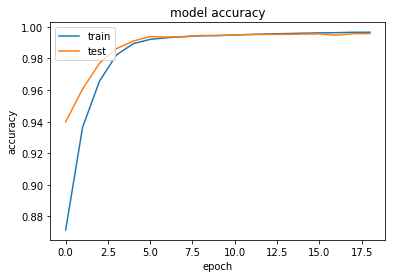

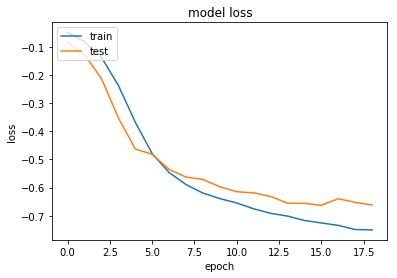

In [14]:
# list all data in history

print(result.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy') #Benennung des Grafen
plt.ylabel('accuracy') #Benennung der y-Achse
plt.xlabel('epoch')    #Benennung der x-Achse
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss') #Benennung des Grafen
plt.ylabel('loss')  #Benennung der y-Achse
plt.xlabel('epoch') #Benennung der x-Achse
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# Evaluate on the test dataset
testInputPath = '/home/dan/Desktop/Datenset_Tower/test/images'
testOutputPath = '/home/dan/Desktop/Datenset_Tower/test/masks'

testGen = loadData(testInputPath, testOutputPath, batch_size)

In [16]:
model.evaluate_generator(testGen, steps=3922/32 ,verbose=1 )

Found 3922 images belonging to 1 classes.
Found 3922 images belonging to 1 classes.
(32, 224, 224, 1)
(32, 224, 224, 1)
123/122 [==============================] - 16s 130ms/step


[-0.6559794531191934, 0.9957407544851911]

In [18]:
predict = model.predict_generator(testGen, steps=3922//batch_size, verbose=1)

122/122 [==============================] - 16s 131ms/step


In [25]:
print (predict.shape)

(3890, 224, 224, 1)


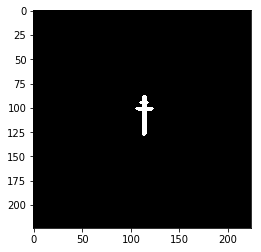

In [27]:
b = 0
i = 80
plt.imshow(predict[i, ..., 0], cmap = 'gray')
plt.show()
#plt.imshow(testGen[b][i, ..., 0], cmap='gray')
#plt.show()

NameError: name 'y' is not defined